In [2]:
#making necessary libs
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin , cos , pi
import cv2
from matplotlib.pyplot import figure

from tqdm.notebook import tqdm

#from keras.layers.advanced_activations import LeakyReLU #
from tensorflow.keras.layers import LeakyReLU
#from keras.models import Sequential, Model , load_model
from tensorflow.keras.models import Sequential, Model , load_model
from tensorflow.keras.layers import Activation , Convolution2D , MaxPooling2D , BatchNormalization , Flatten , Dense , Dropout, Conv2D, MaxPool2D,ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.optimizers import Adam



 ## Augmentation & Hyperparameter settings
 ### experiment with various augmentation choices
 

In [2]:
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True 
random_noise_augmentation = True

include_unclear_data = True  # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.

sample_image_index = 20  # Index of sample train image used for visualizing various augmentations
rotation_angles = [12]  # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12] # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners
NUM_EPOCHS = 80
BATCH_SIZE = 64


## extracting files to working directory

In [3]:
train_file = pd.read_csv("training.csv")
test_file = pd.read_csv("test.csv")
idlookup_file = pd.read_csv("IdLookupTable.csv")

##  function to plot keypoints with image

In [15]:
def plot_sample(image, keypoint , axis , title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap = 'gray')
    axis.scatter(keypoint[0::2],keypoint[1::2],marker='x',s=20)
    plt.title(title)
    

## Exploring data

In [5]:
train_file.T

0     \
left_eye_center_x                                                    66.0336   
left_eye_center_y                                                    39.0023   
right_eye_center_x                                                    30.227   
right_eye_center_y                                                   36.4217   
left_eye_inner_corner_x                                              59.5821   
left_eye_inner_corner_y                                              39.6474   
left_eye_outer_corner_x                                              73.1303   
left_eye_outer_corner_y                                                39.97   
right_eye_inner_corner_x                                             36.3566   
right_eye_inner_corner_y                                             37.3894   
right_eye_outer_corner_x                                             23.4529   
right_eye_outer_corner_y                                             37.3894   
left_eyebrow_inner_end_x                                             56.9533   
left_eyebrow_inner_end_y                                             29.0336   
left_eyebrow_outer_end_x                                             80.2271   
left_eyebrow_outer_end_y                                             32.2281   
right_eyebrow_inner_end_x                                            40.2276   
right_eyebrow_inner_end_y                                            29.0023   
right_eyebrow_outer_end_x                                            16.3564   
right_eyebrow_outer_end_y                                            29.6475   
nose_tip_x                                                           44.4206   
nose_tip_y                                                           57.0668   
mouth_left_corner_x                                                  61.1953   
mouth_left_corner_y                                                  79.9702   
mouth_right_corner_x                                                 28.6145   
mouth_right_corner_y                                                  77.389   
mouth_center_top_lip_x                                               43.3126   
mouth_center_top_lip_y                                               72.9355   
mouth_center_bottom_lip_x                                            43.1307   
mouth_center_bottom_lip_y                                            84.4858   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                        1     \
left_eye_center_x                                                    64.3329   
left_eye_center_y                                                    34.9701   
right_eye_center_x                                                   29.9493   
right_eye_center_y                                                   33.4487   
left_eye_inner_corner_x                                              58.8562   
left_eye_inner_corner_y                                              35.2743   
left_eye_outer_corner_x                                              70.7227   
left_eye_outer_corner_y                                              36.1872   
right_eye_inner_corner_x                                             36.0347   
right_eye_inner_corner_y                                             34.3615   
right_eye_outer_corner_x                                             24.4725   
right_eye_outer_corner_y                                             33.1444   
left_eyebrow_inner_end_x                                             53.9874   
left_eyebrow_inner_end_y                                             28.2759   
left_eyebrow_outer_end_x                                             78.6342   
left_eyebrow_outer_end_y                                             30.4059   
right_eyebrow_inner_end_x                                            42.7289   
right_eyebrow_inner_end_y                                             2

In [6]:
test_file


ImageId                                              Image
0           1  182 183 182 182 180 180 176 169 156 137 124 10...
1           2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2           3  177 176 174 170 169 169 168 166 166 166 161 14...
3           4  176 174 174 175 174 174 176 176 175 171 165 15...
4           5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...       ...                                                ...
1778     1779  101 101 101 100 100 97 97 98 102 149 214 206 1...
1779     1780  201 191 171 158 145 140 136 130 123 115 108 10...
1780     1781  28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781     1782  104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...
1782     1783  63 61 64 66 66 64 65 70 69 70 77 83 63 34 22 2...

[1783 rows x 2 columns]

In [7]:
idlookup_file.T

0                  1                   2      \
RowId                        1                  2                   3   
ImageId                      1                  1                   1   
FeatureName  left_eye_center_x  left_eye_center_y  right_eye_center_x   
Location                   NaN                NaN                 NaN   

                          3                        4      \
RowId                         4                        5   
ImageId                       1                        1   
FeatureName  right_eye_center_y  left_eye_inner_corner_x   
Location                    NaN                      NaN   

                               5                        6      \
RowId                              6                        7   
ImageId                            1                        1   
FeatureName  left_eye_inner_corner_y  left_eye_outer_corner_x   
Location                         NaN                      NaN   

                               7                         8      \
RowId                              8                         9   
ImageId                            1                         1   
FeatureName  left_eye_outer_corner_y  right_eye_inner_corner_x   
Location                         NaN                       NaN   

                                9      ...                      27114  \
RowId                              10  ...                      27115   
ImageId                             1  ...                       1782   
FeatureName  right_eye_inner_corner_y  ...  mouth_center_bottom_lip_x   
Location                          NaN  ...                        NaN   

                                 27115              27116              27117  \
RowId                            27116              27117              27118   
ImageId                           1782               1783               1783   
FeatureName  mouth_center_bottom_lip_y  left_eye_center_x  left_eye_center_y   
Location                           NaN                NaN                NaN   

                          27118               27119       27120       27121  \
RowId                     27119               27120       27121       27122   
ImageId                    1783                1783        1783        1783   
FeatureName  right_eye_center_x  right_eye_center_y  nose_tip_x  nose_tip_y   
Location                    NaN                 NaN         NaN         NaN   

                                 27122                      27123  
RowId                            27123                      27124  
ImageId                           1783                       1783  
FeatureName  mouth_center_bottom_lip_x  mouth_center_bottom_lip_y  
Location                           NaN                        NaN  

[4 rows x 27124 columns]

## check for any images with missing pixel values

In [8]:
print("Length of training data : {}:".format(len(train_file)))
print("number Of Image with missing pixel values: {}".format(len(train_file)- int(train_file.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of training data : 7049:
number Of Image with missing pixel values: 0


## Find columns having Null values and their counts

In [9]:
train_file.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

 ## We can observe that approx 68% of data is midding for several keypoints

In [10]:
%%time
clean_train_data = train_file.dropna()
print("clean_train_data shape {}".format(np.shape(clean_train_data)))
unclean_train_data = train_file.fillna(method='ffill')
print("unclean_train_data shape {}".format(np.shape(unclean_train_data)))


clean_train_data shape (2140, 31)
unclean_train_data shape (7049, 31)
Wall time: 19.6 ms


## separate data into clean & unclean subsets


shape of clean_train_images: (2140, 96, 96, 1)
shape of clean_train_keypoints: (2140, 30)
shape of test_images : (1783, 96, 96, 1)
Shape of train_images: (2140, 96, 96, 1)
Shape of train_keypoints: (2140, 30)
Wall time: 12.2 s


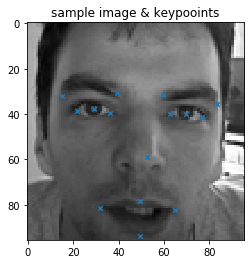

In [11]:
%%time
include_unclear_data = 0
## Load image
def load_images(image_data):
    images = []
    for idx , sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '),dtype= int)
        image = np.reshape(image,(96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images


## Load keypoints
def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis =1)
    keypoint_feature = []
    for idx , sample_keypoint in keypoint_data.iterrows():
        keypoint_feature.append(sample_keypoint)
    keypoint_feature = np.array(keypoint_feature,dtype = "float")
    return keypoint_feature

clean_train_images = load_images(clean_train_data)
print("shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints =load_keypoints(clean_train_data)
print("shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_file)
print("shape of test_images : {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
print("Shape of train_images: {}".format(np.shape(train_images)))
print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
fig , axis = plt.subplots()
plot_sample(clean_train_images[5], clean_train_keypoints[5], axis , "sample image & keypooints")
if include_unclear_data:
    unclean_train_image = load_images(unclean_train_data)
    print("shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("shape of unclean_train_keypoints: {}".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images,unclean_train_image))
    train_keypoints = np.concatenate((train_keypoints,unclean_train_keypoints))
    
    

## performing Horizontal fliping for Data augmentation

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)
Shape of train: (4280, 96, 96, 1)
Shape of train_keypoints: (4280, 30)


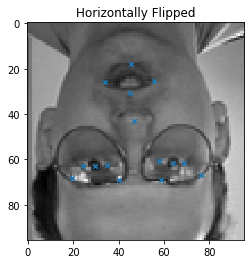

In [12]:
horizontal_flip = 1
sample_image_index =6
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=1)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2!=0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of train_images: {}".format(np.shape(train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    print("Shape of train: {}".format(np.shape(train_images)))
    print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

 ## Performing Rotation Augmentation

Shape of rotated_train_images: (8560, 96, 96, 1)
Shape of rotated_train_keypoints: (8560, 30)
Shape of train: (12840, 96, 96, 1)
Shape of train_keypoints: (12840, 30)


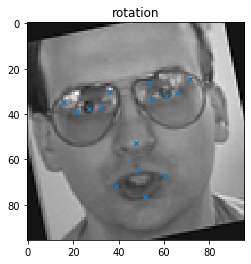

In [13]:
def rotation_aug(images,keypoints):
    rotated_images=[]
    rotated_keypoints=[]
    angles = [12,45]
    for angle in angles:
        for angle in [angle,-angle]:
            M = cv2.getRotationMatrix2D((48,48),angle,1.0)
            theta = -angle*pi/180
            
            #images
            for image in images:
                rotated_image= cv2.warpAffine(image,M,(96,96),flags = cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            
            #keypoint
            
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48. 
                '''shift the points in the plane so that the desired center of rotation moves to the origin.''' 
                for idx in range(0,len(rotated_keypoint),2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(theta)-rotated_keypoint[idx+1]*sin(theta)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(theta)+rotated_keypoint[idx+1]*cos(theta)
                    '''  do the rotation about the origin with the above formula. '''
                rotated_keypoint += 48
                ''' after the rotation is done, shift the points back so that the center of origin.  '''
                rotated_keypoints.append(rotated_keypoint)
    return np.reshape(rotated_images,(-1,96,96,1)) , rotated_keypoints

                
if rotation_augmentation:
    rotated_train_images , rotated_train_keypoints = rotation_aug(clean_train_images,clean_train_keypoints)
    print("Shape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    print("Shape of train: {}".format(np.shape(train_images)))
    print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "rotation") 

## performing Brightness Alteration for Data Augmentation 



Shape of alter_brightness_train_images: (4280, 96, 96, 1)
Shape of alter_brightness_train_keypoints: (4280, 30)
Shape of train: (17120, 96, 96, 1)
Shape of train_keypoints: (17120, 30)


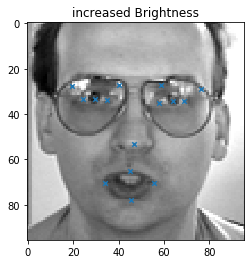

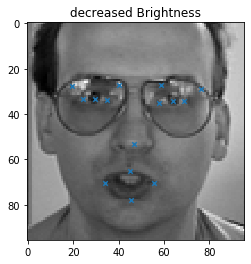

In [14]:
sample_image_index = 6
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.5,0.0,1.0)
    dec_brightness_images = np.clip(images*0.06,0.0,1.0)
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images , np.concatenate((keypoints,keypoints))


if brightness_augmentation:
    alter_brightness_train_images , alter_brightness_train_keypoints = alter_brightness(clean_train_images,clean_train_keypoints)
    print("Shape of alter_brightness_train_images: {}".format(np.shape(alter_brightness_train_images)))
    print("Shape of alter_brightness_train_keypoints: {}".format(np.shape(alter_brightness_train_keypoints)))
    train_images = np.concatenate((train_images,alter_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints,alter_brightness_train_keypoints))
    print("Shape of train: {}".format(np.shape(train_images)))
    print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
    fig, axis = plt.subplots()
    plot_sample(alter_brightness_train_images[sample_image_index], alter_brightness_train_keypoints[sample_image_index], axis, "increased Brightness")
    fig, axis = plt.subplots()
    plot_sample(alter_brightness_train_images[len(alter_brightness_train_images)//2+sample_image_index], alter_brightness_train_keypoints[len(alter_brightness_train_keypoints)//2+sample_image_index], axis, "decreased Brightness")
    
    
    
    

## Performing Horizontal & Vertical shift

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_images: (17120, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)
Shape of train: (23470, 96, 96, 1)
Shape of train_keypoints: (23470, 30)


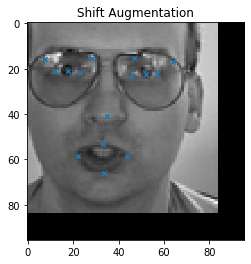

In [15]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_images: {np.shape(train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images,shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints,shifted_train_keypoints))
    print("Shape of train: {}".format(np.shape(train_images)))
    print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

## Adding Random Noise for data Augmentation

Shape of noisy_train_images: (2140, 96, 96, 1)
Shape of train_keypoints: (25610, 30)
Shape of train: (25610, 96, 96, 1)


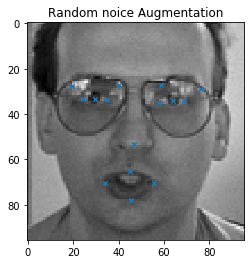

In [16]:
def add_noice(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image,0.008*np.random.randn(96,96,1))
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images
if random_noise_augmentation:
    noisy_train_images = add_noice(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images,noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints,clean_train_keypoints))
    print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
    print("Shape of train: {}".format(np.shape(train_images)))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random noice Augmentation")


## Visualize Train images & corresponding Keypoints

Shape of total train_image (25610, 96, 96, 1)
Shape of total train_keypoints (25610, 30)

 Clear Train Data: 


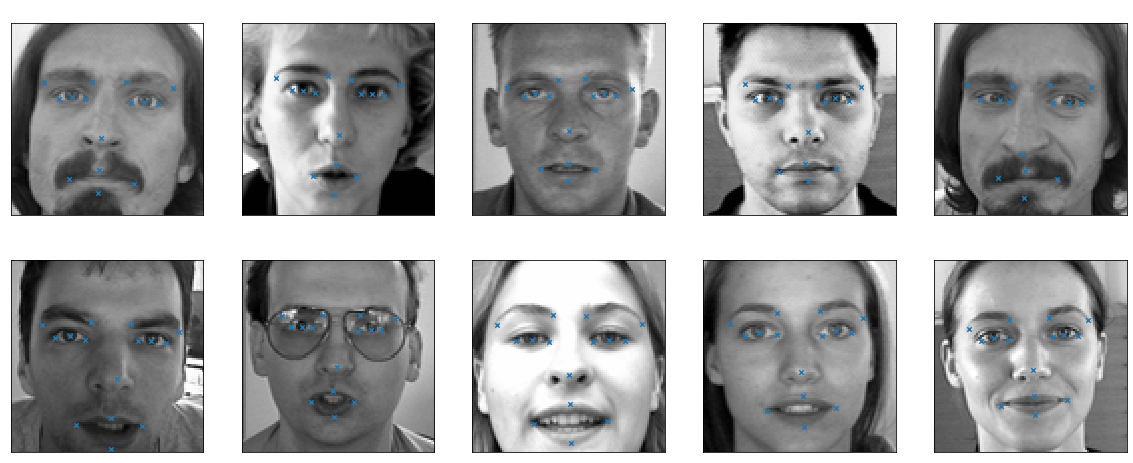


 Horizontal Augmentation: 


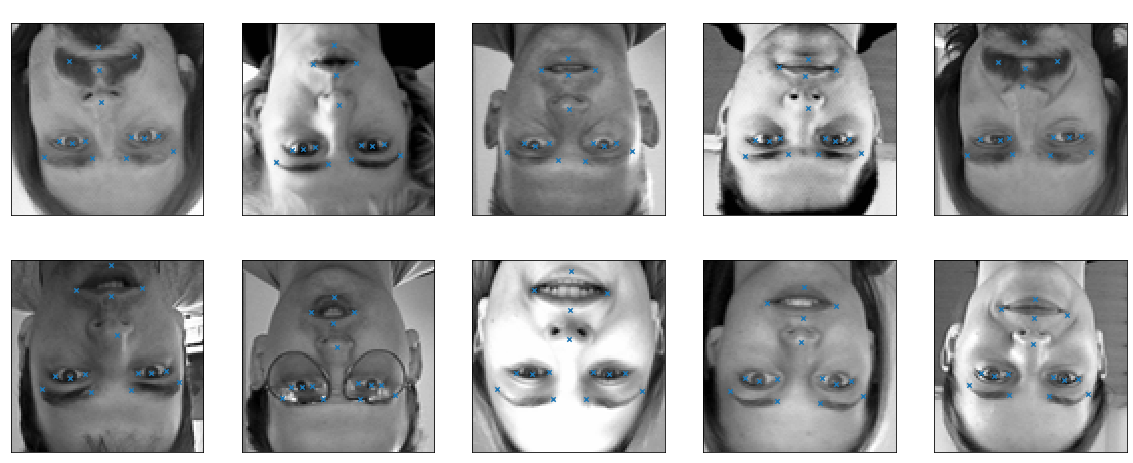


 rotation Augmentation: 


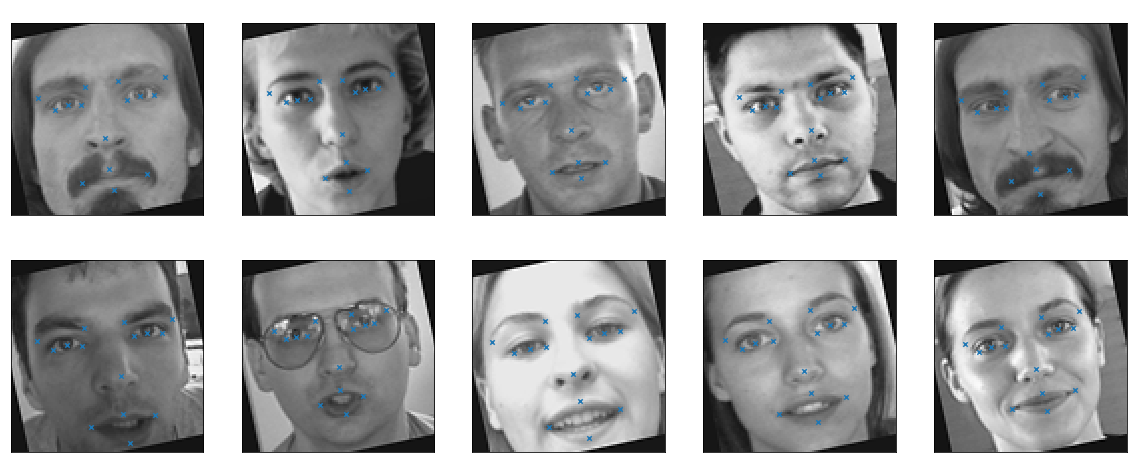


 Brightness Augmentation: 


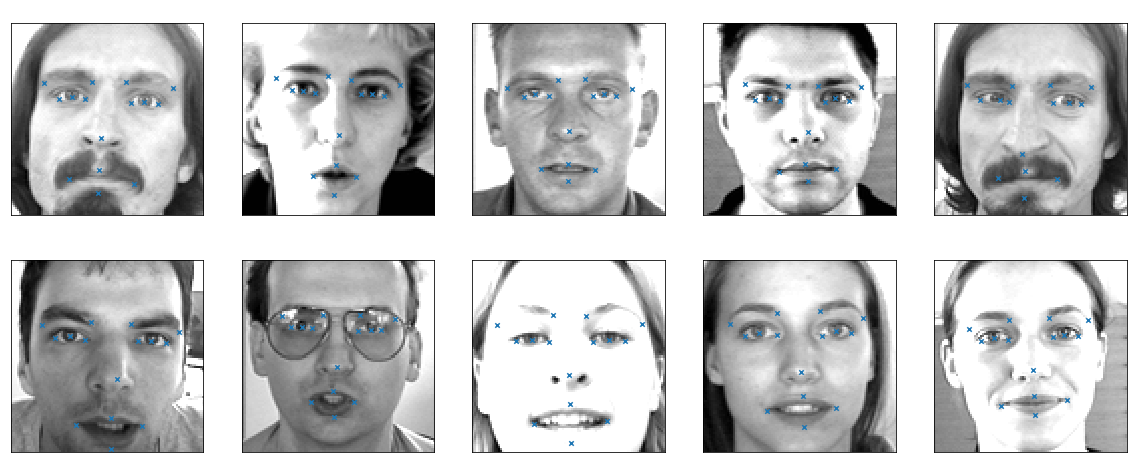


 Shift Augmentation: 


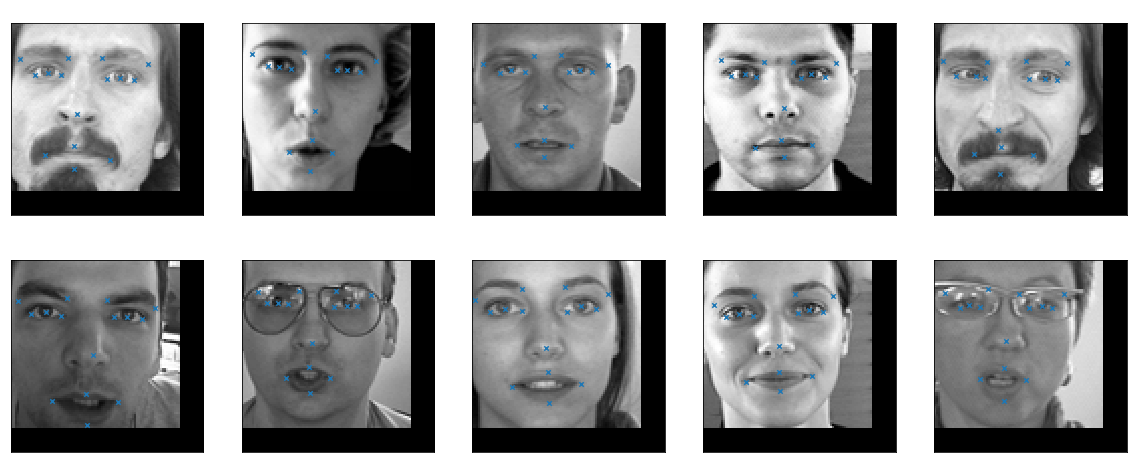


 Random noise Augmentation: 


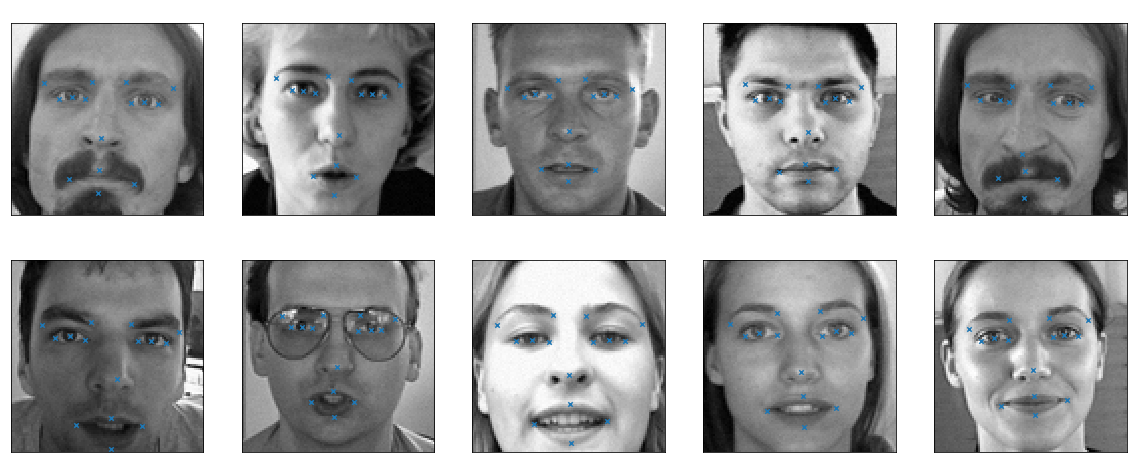

In [17]:
print("Shape of total train_image {}".format(np.shape(train_images)))
print("Shape of total train_keypoints {}".format(np.shape(train_keypoints)))


print("\n Clear Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
    plot_sample(clean_train_images[i],clean_train_keypoints[i],axis," ")
plt.show()
    
    
if include_unclear_data:
    print("\n unClear Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(unclean_train_image[i],unclean_train_keypoints[i],axis," ")
    plt.show()
    
if horizontal_flip:
    print("\n Horizontal Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(flipped_train_images[i],flipped_train_keypoints[i],axis," ")
    plt.show()
    
if rotation_augmentation:
    print("\n rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(rotated_train_images[i],rotated_train_keypoints[i],axis," ")
    plt.show()


if brightness_augmentation:
    print("\n Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(alter_brightness_train_images[i],alter_brightness_train_keypoints[i],axis," ")
    plt.show()
    
    
if shift_augmentation:
    print("\n Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(shifted_train_images[i],shifted_train_keypoints[i],axis," ")
    plt.show()
    
    
if random_noise_augmentation:
    print("\n Random noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1, xticks=[] ,yticks=[])
        plot_sample(noisy_train_images[i],clean_train_keypoints[i],axis," ")
    plt.show()

## Building a model 

In [37]:
model = Sequential()
#input dim: (None, 96,96,1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False , input_shape = (96,96,1)))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 96,96,32)
model.add(Convolution2D(32,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


#input dim: (None, 48,48,32)
model.add(Convolution2D(64,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 48,48,64)
model.add(Convolution2D(64,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


#input dim: (None, 24,24,64)
model.add(Convolution2D(96,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 24,24,96)
model.add(Convolution2D(96,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


#input dim: (None, 12,12,96)
model.add(Convolution2D(128,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 12,12,128)
model.add(Convolution2D(128,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

#input dim: (None, 6,6,128)
model.add(Convolution2D(256,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 6,6,256)
model.add(Convolution2D(256,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


#input dim: (None, 3,3,256)
model.add(Convolution2D(512,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())
#input dim: (None, 3,3,512)
model.add(Convolution2D(512,(3,3), padding= 'same', use_bias=False))
model.add(LeakyReLU(alpha = .1))
model.add(BatchNormalization())


#input dim: (None,3,3,512)
model.add(Flatten())
model.add(Dense(512,activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()








Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)       

In [40]:
len(train_images)

25610

## Training the model 

In [ ]:
%%time
# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath= 'best_model.hdf5',monitor='val_mae',verbose=1,save_best_only=True,mode='min')

#compile the model
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae','acc'])

#Train the model
history = model.fit(train_images,train_keypoints,epochs=NUM_EPOCHS, batch_size=BATCH_SIZE , validation_split=0.05 ,callbacks=[checkpointer])

Epoch 1/80
381/381 [==============================] - ETA: 0s - loss: 27.6426 - mae: 3.8410 - acc: 0.6752
Epoch 00001: val_mae improved from inf to 2.88920, saving model to best_model.hdf5
381/381 [==============================] - 2708s 7s/step - loss: 27.6426 - mae: 3.8410 - acc: 0.6752 - val_loss: 13.6480 - val_mae: 2.8892 - val_acc: 0.6589
Epoch 2/80
381/381 [==============================] - ETA: 0s - loss: 12.0804 - mae: 2.6903 - acc: 0.7722
Epoch 00002: val_mae improved from 2.88920 to 1.44947, saving model to best_model.hdf5
381/381 [==============================] - 2455s 6s/step - loss: 12.0804 - mae: 2.6903 - acc: 0.7722 - val_loss: 3.9707 - val_mae: 1.4495 - val_acc: 0.6425
Epoch 3/80
381/381 [==============================] - ETA: 0s - loss: 9.9662 - mae: 2.4369 - acc: 0.7979
Epoch 00003: val_mae did not improve from 1.44947
381/381 [==============================] - 2454s 6s/step - loss: 9.9662 - mae: 2.4369 - acc: 0.7979 - val_loss: 7.8257 - val_mae: 2.2459 - val_acc: 0.

In [19]:
model =load_model('best_model.hdf5')
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image


C:\Users\Sourav Saha\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


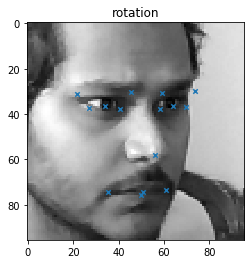

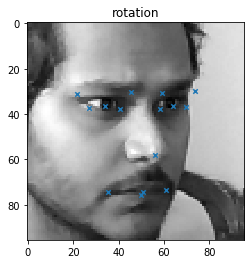

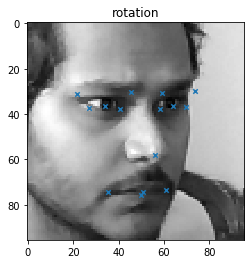

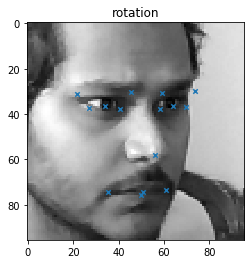

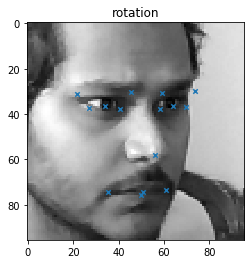

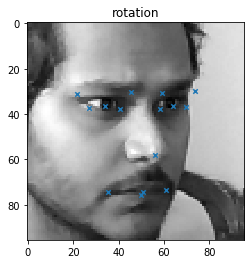

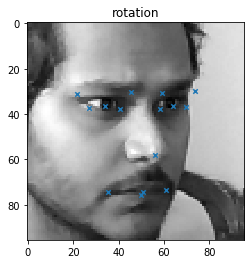

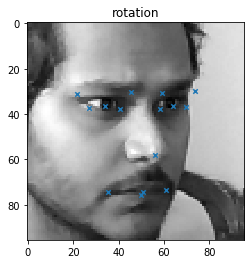

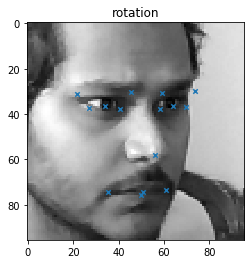

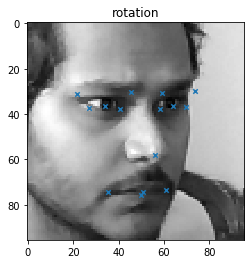

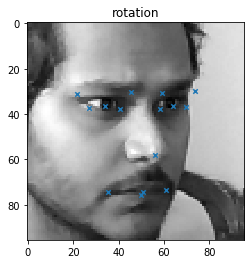

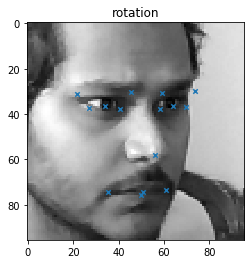

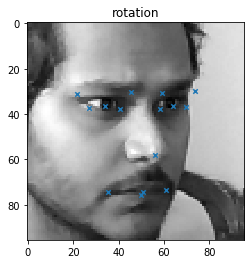

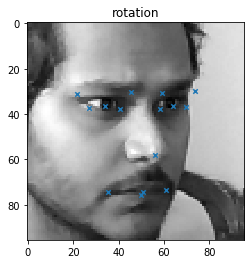

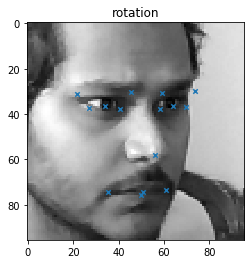

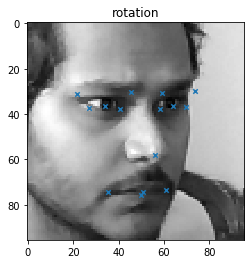

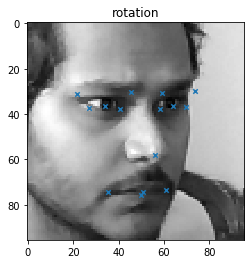

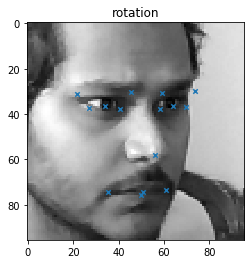

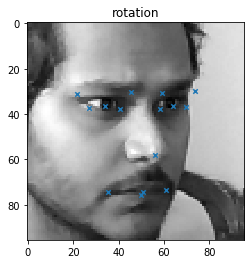

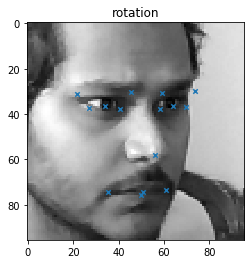

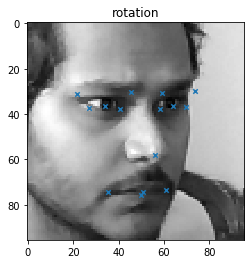

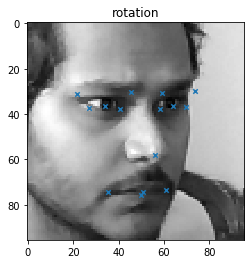

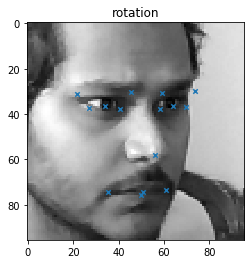

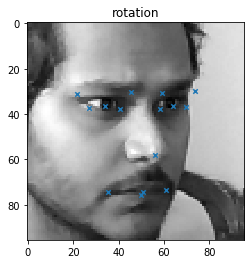

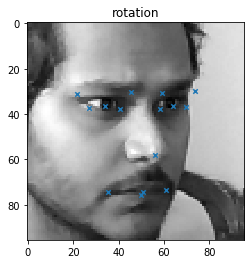

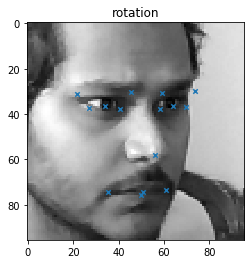

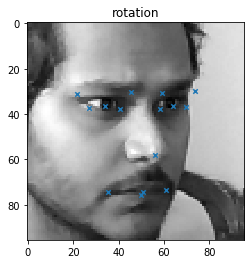

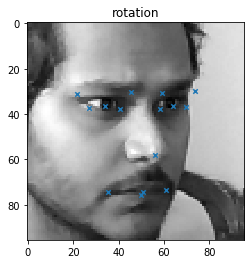

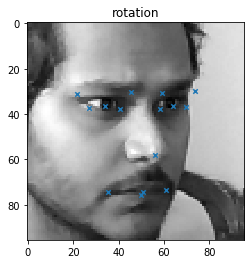

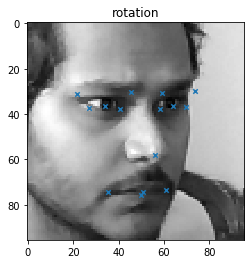

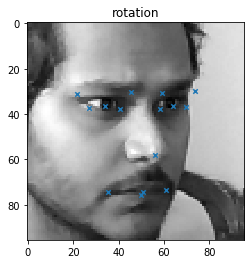

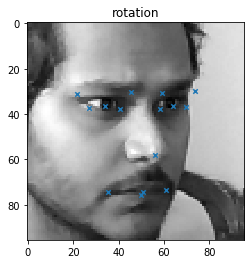

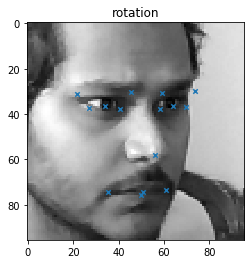

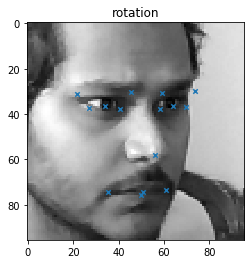

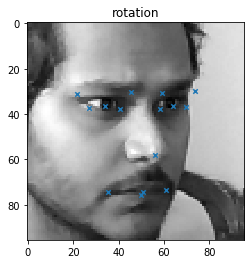

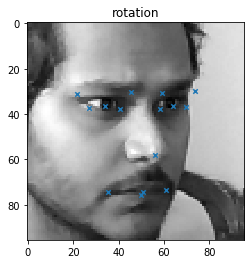

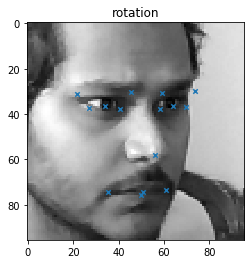

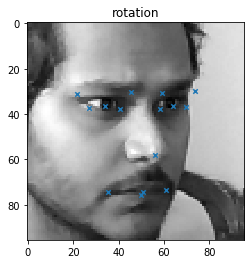

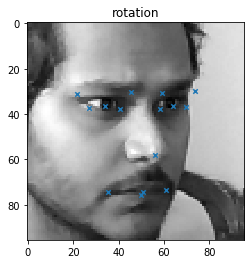

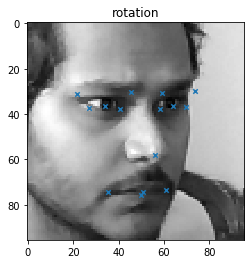

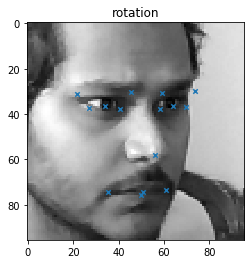

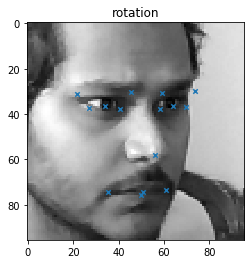

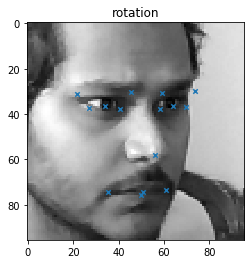

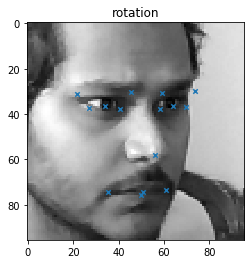

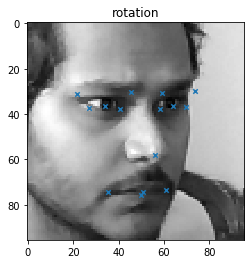

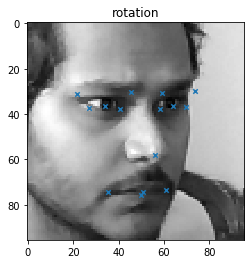

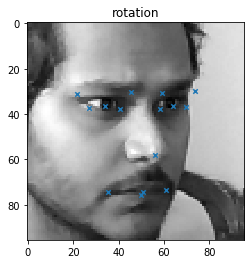

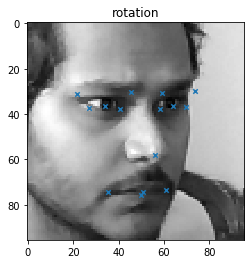

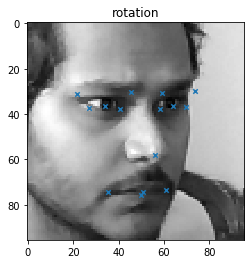

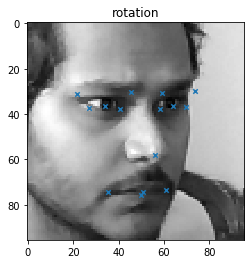

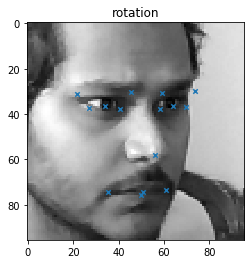

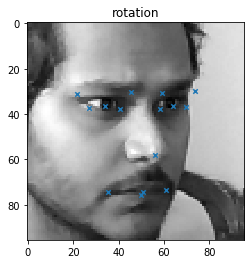

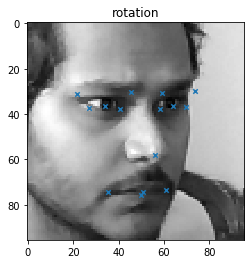

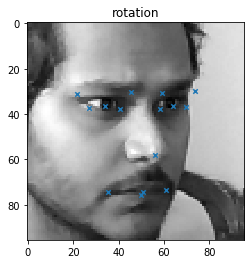

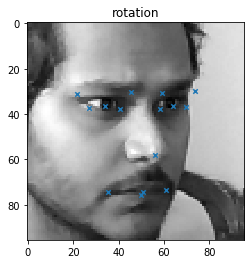

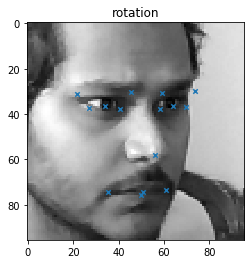

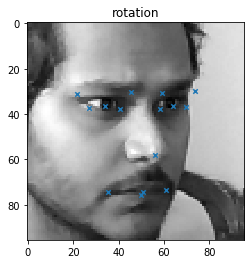

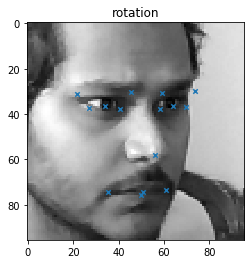

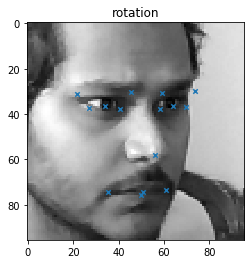

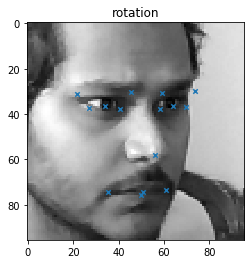

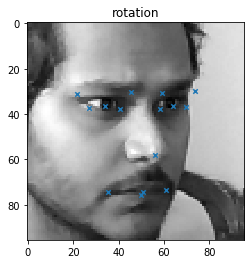

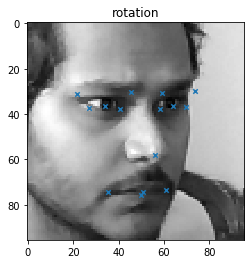

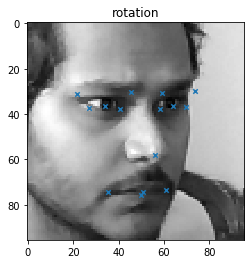

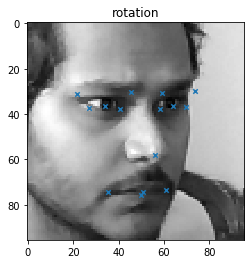

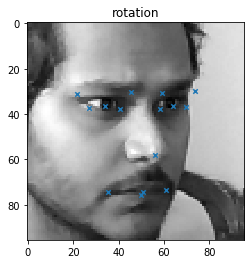

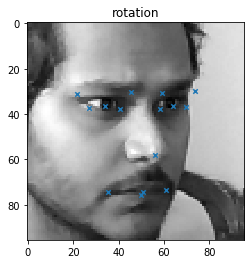

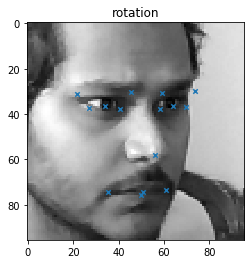

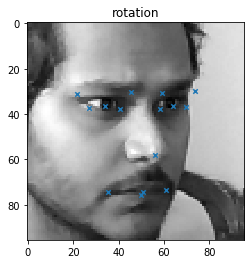

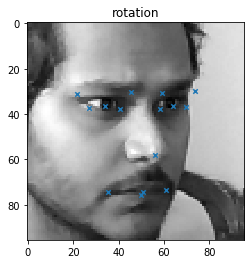

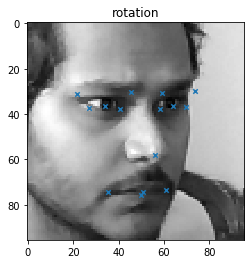

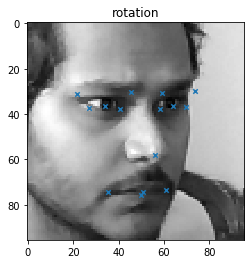

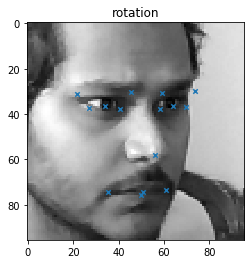

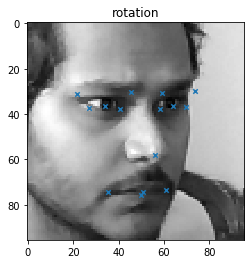

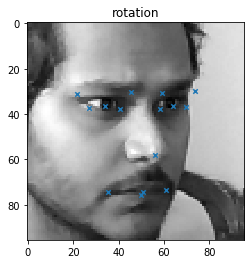

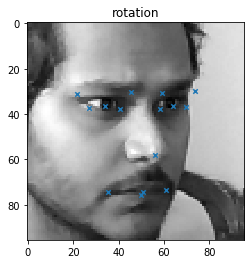

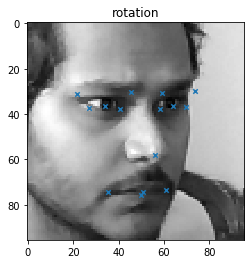

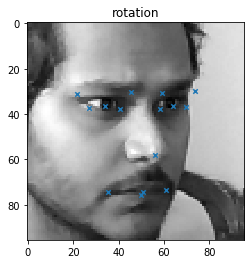

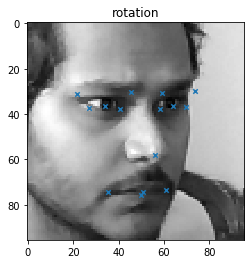

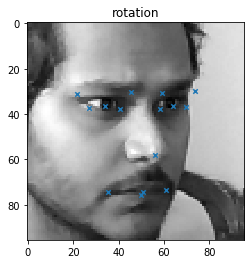

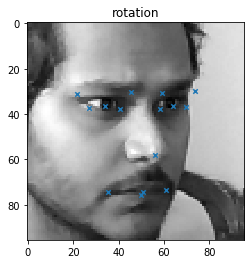

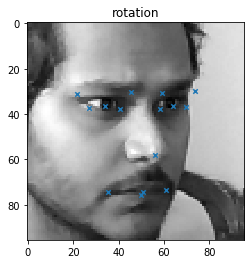

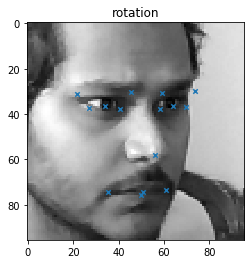

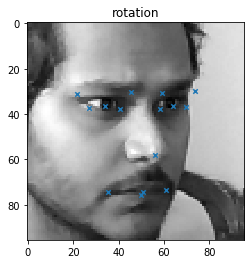

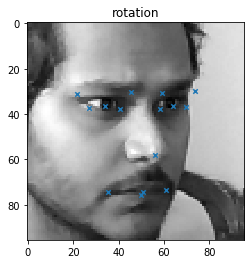

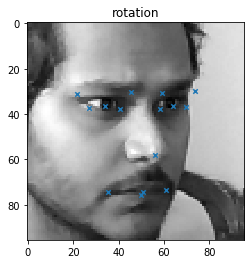

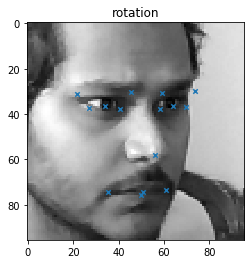

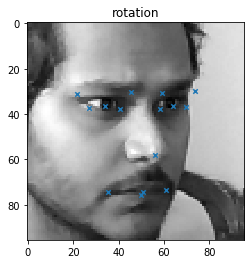

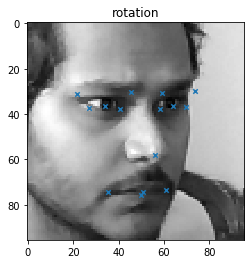

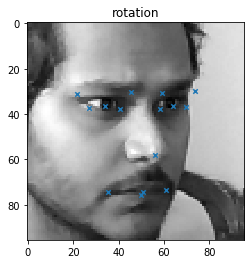

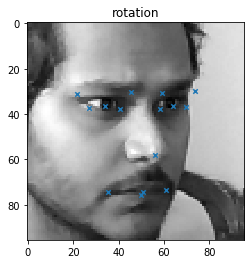

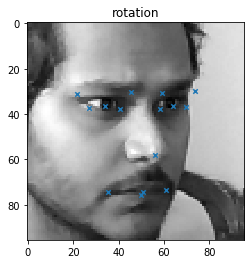

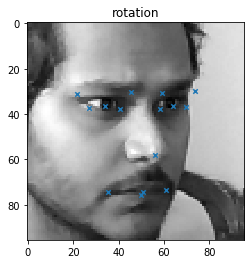

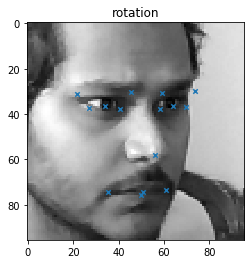

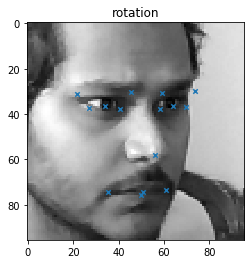

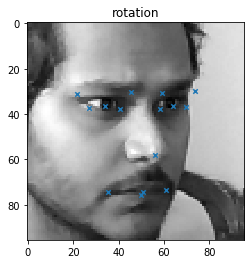

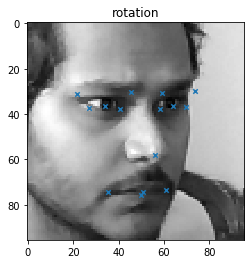

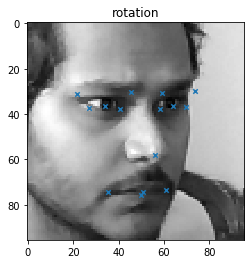

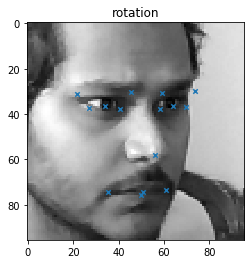

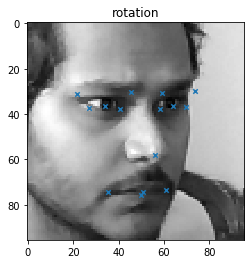

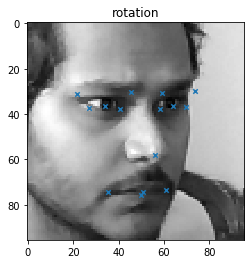

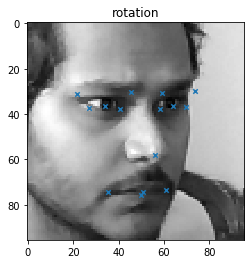

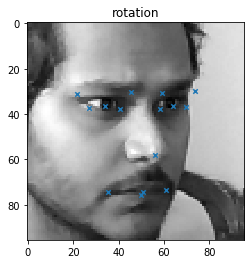

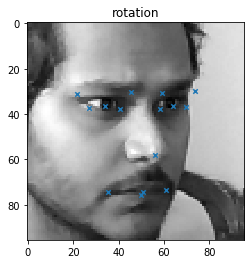

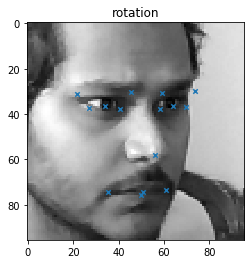

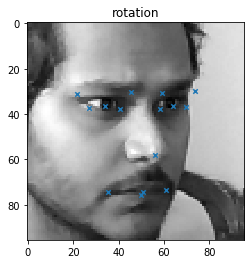

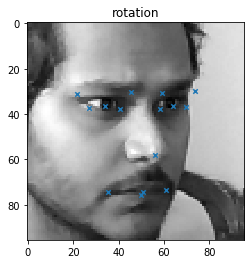

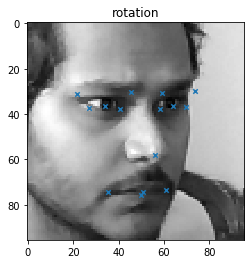

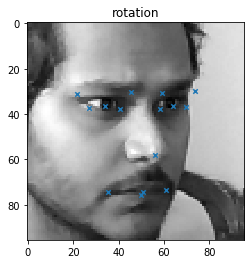

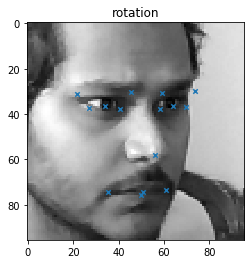

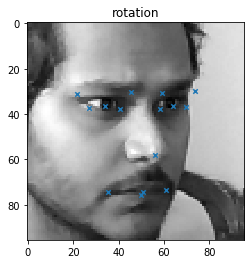

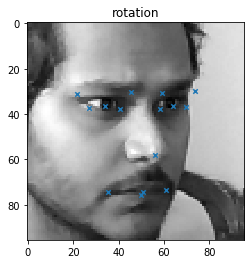

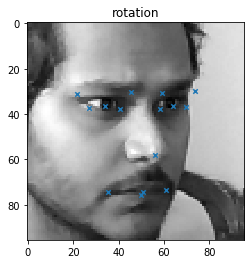

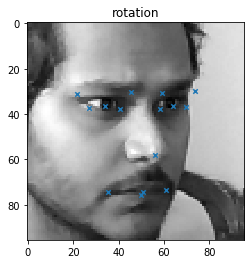

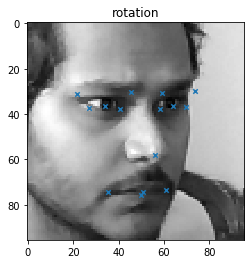

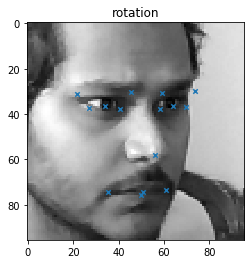

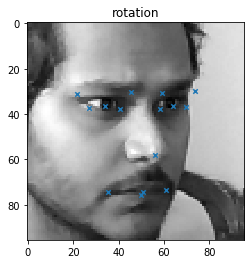

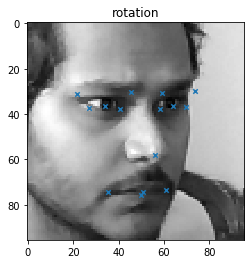

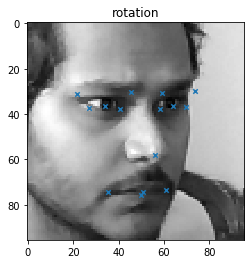

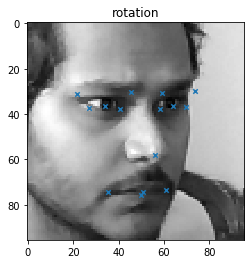

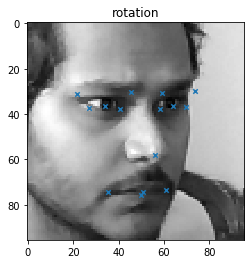

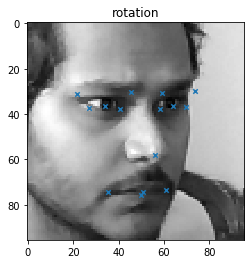

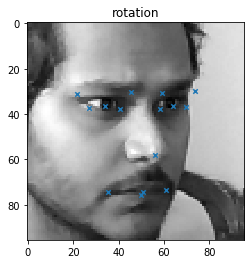

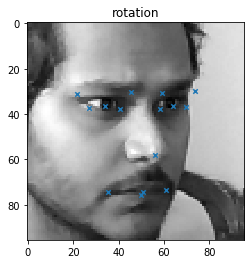

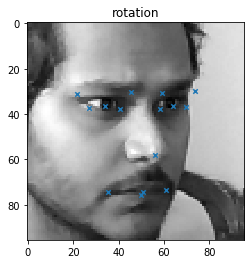

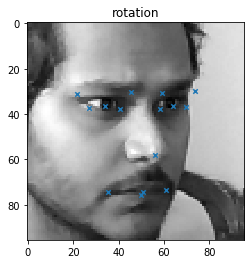

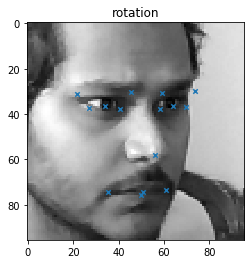

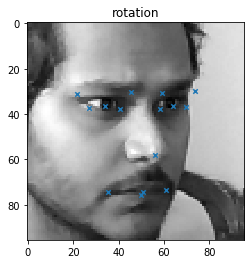

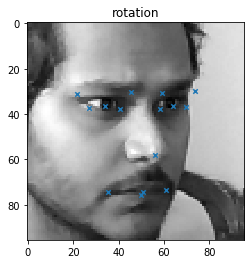

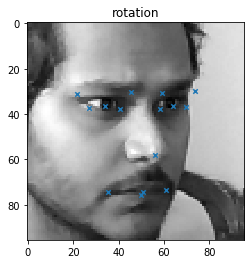

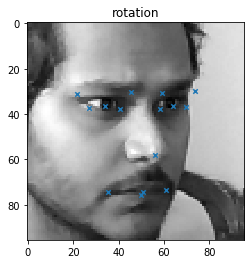

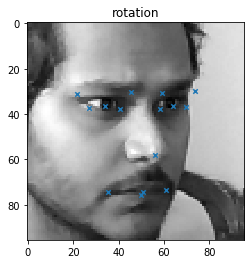

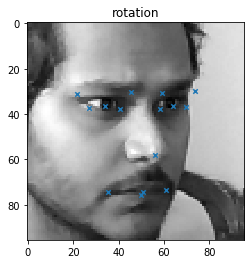

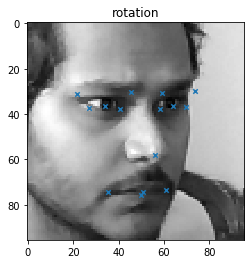

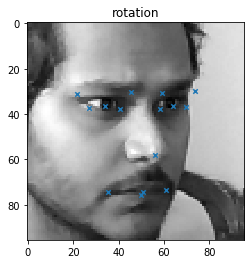

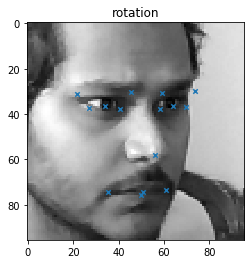

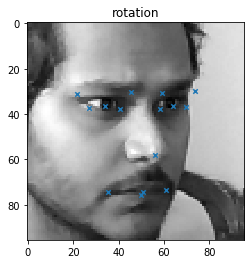

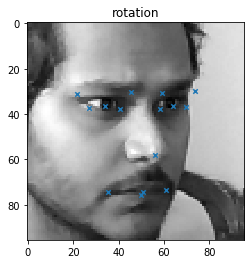

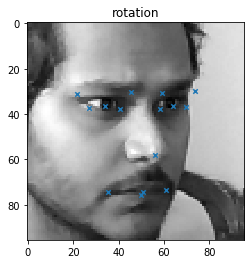

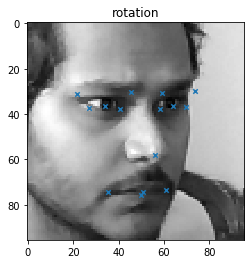

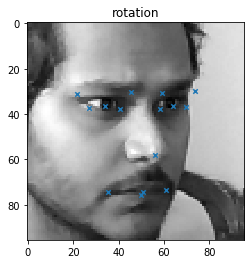

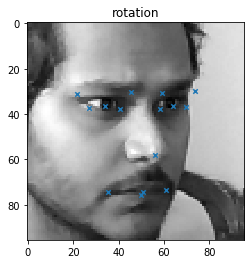

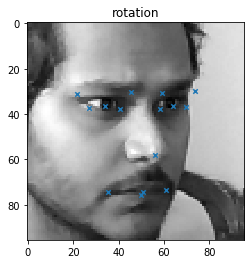

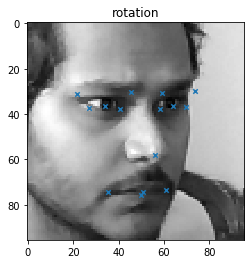

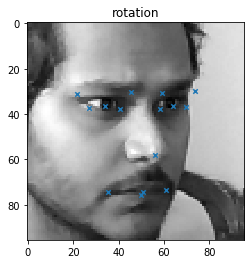

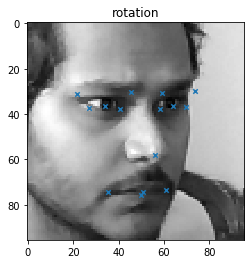

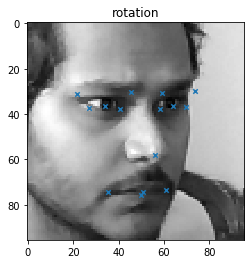

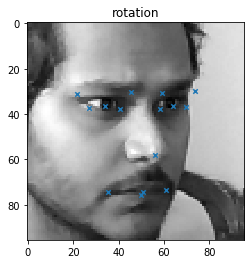

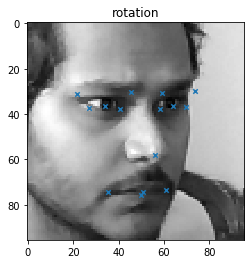

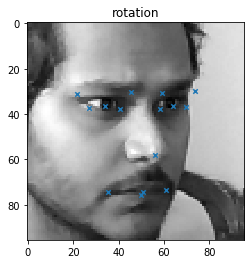

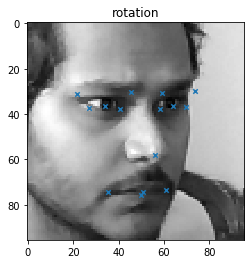

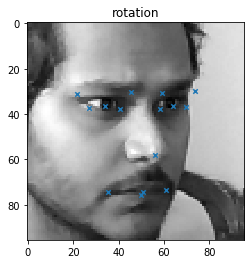

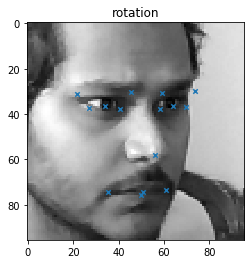

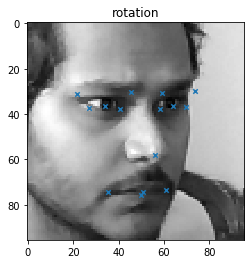

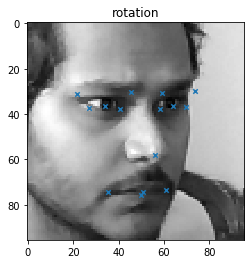

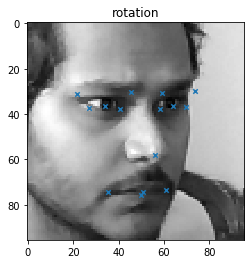

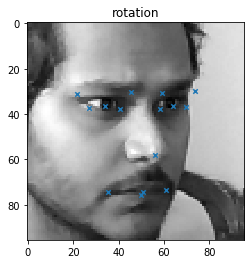

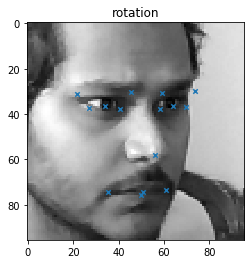

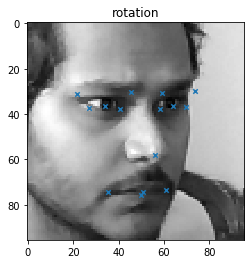

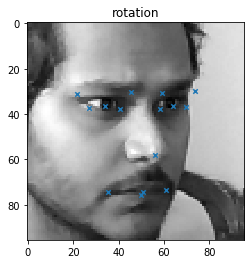

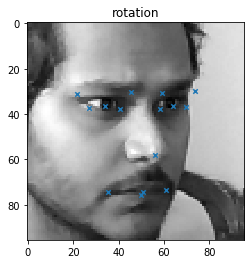

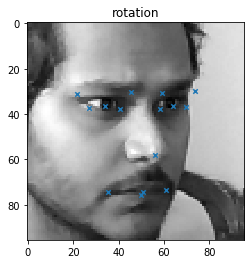

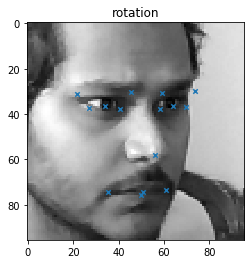

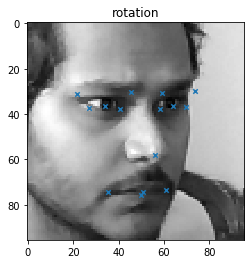

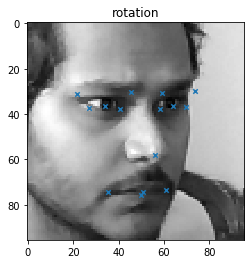

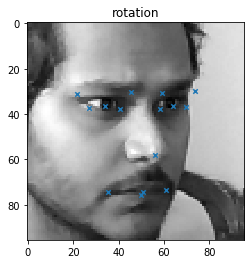

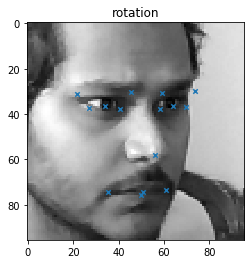

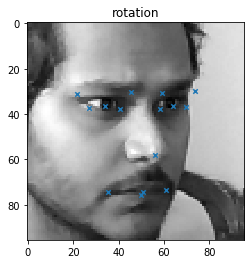

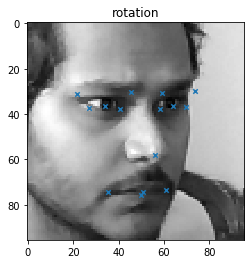

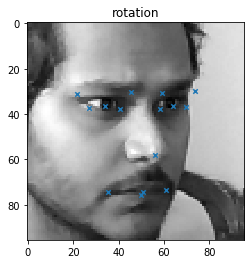

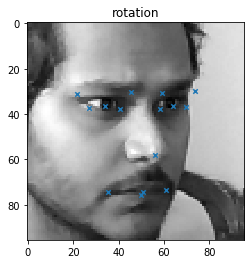

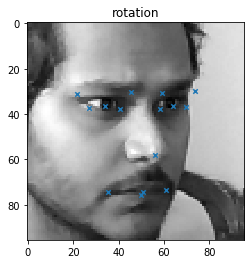

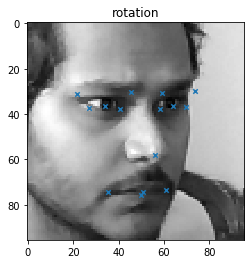

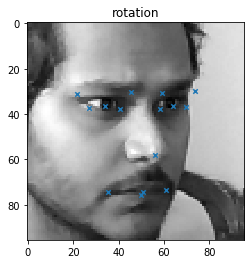

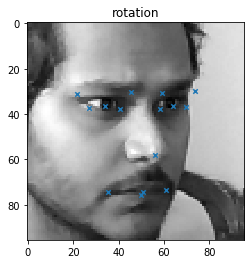

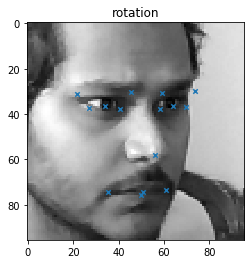

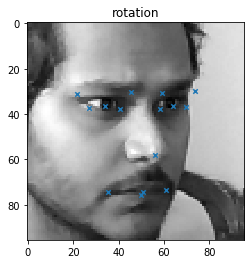

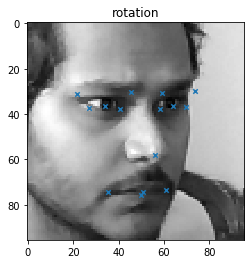

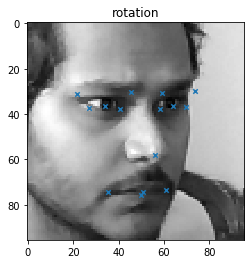

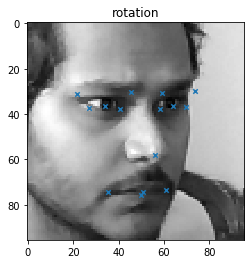

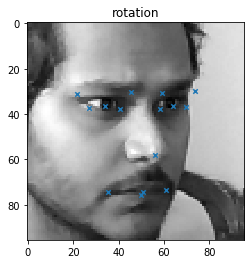

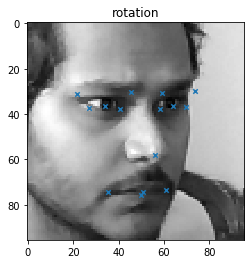

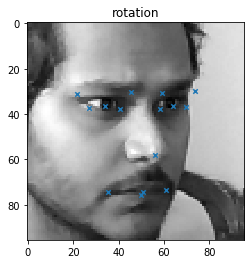

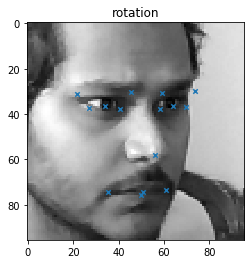

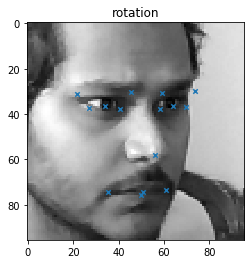

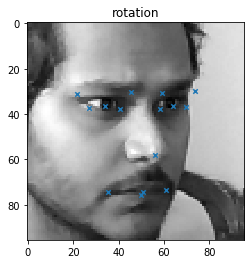

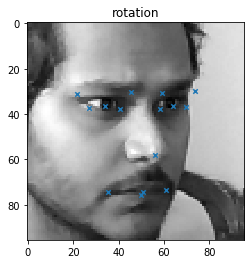

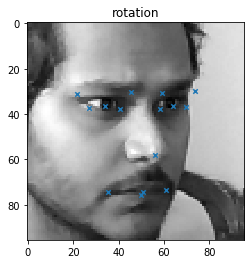

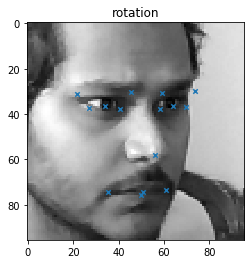

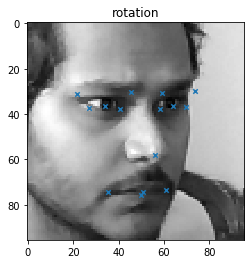

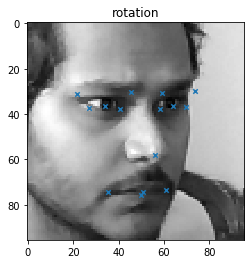

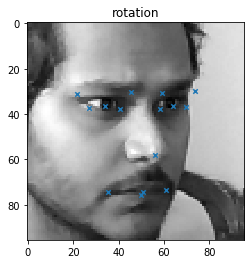

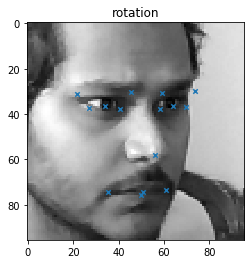

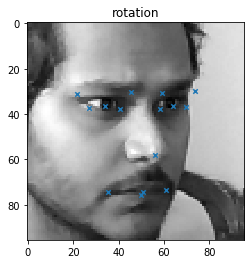

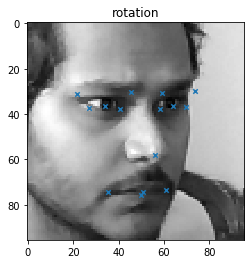

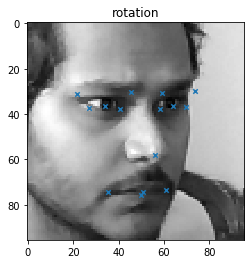

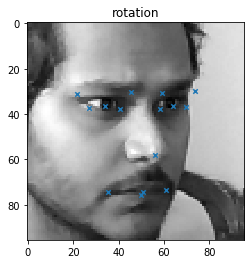

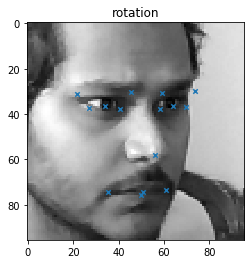

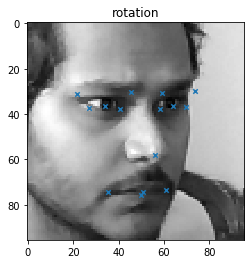

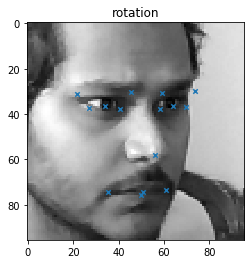

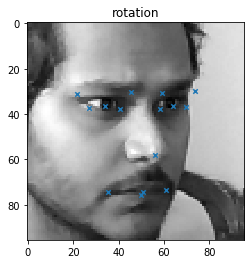

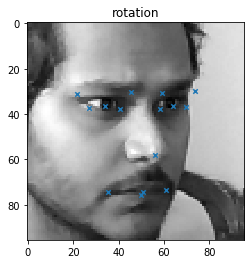

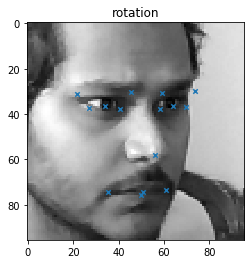

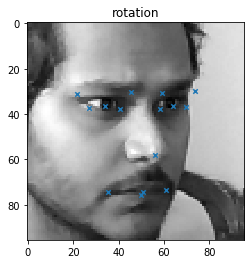

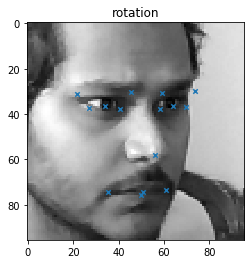

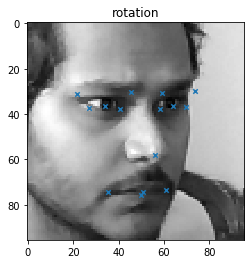

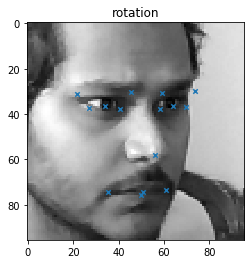

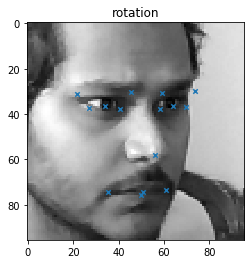

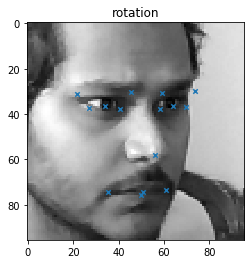

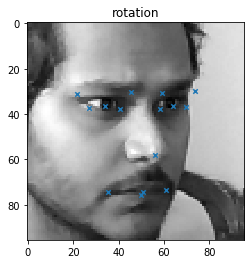

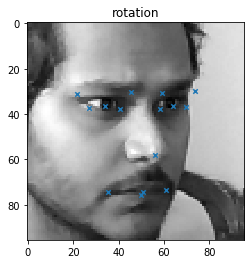

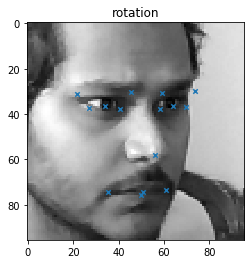

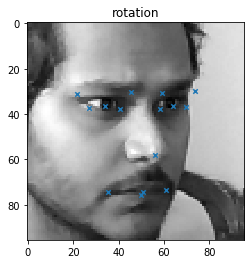

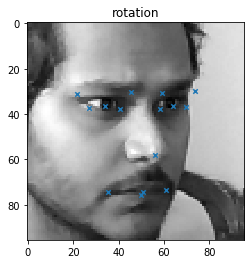

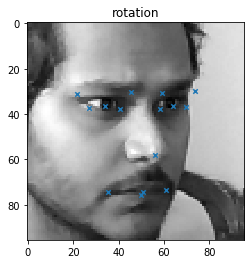

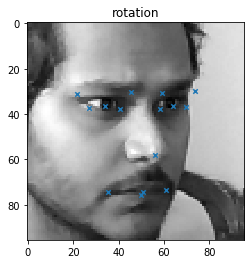

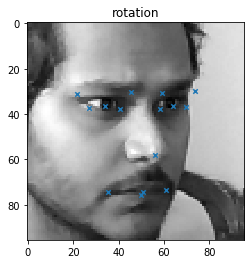

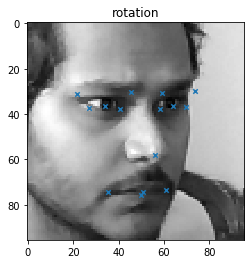

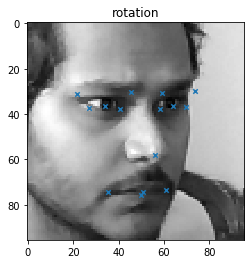

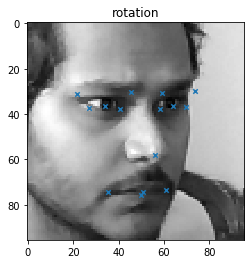

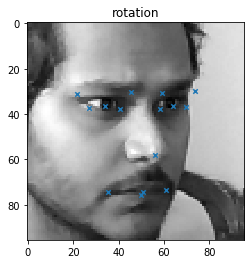

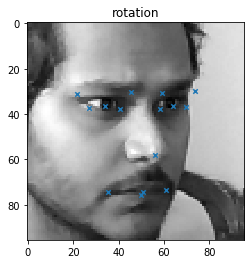

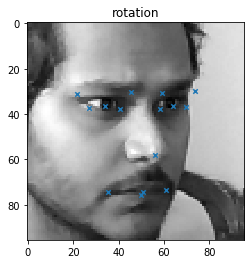

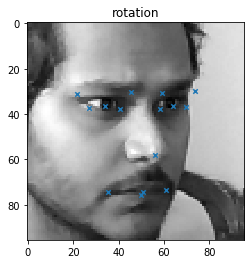

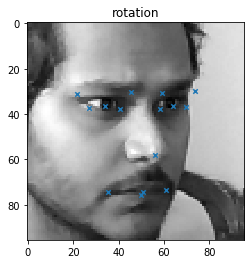

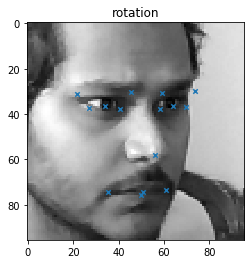

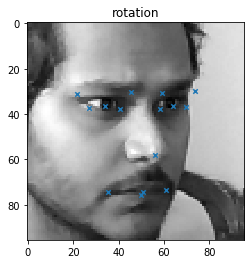

Error in callback <function flush_figures at 0x0000019C2C91A4C8> (for post_execute):


KeyboardInterrupt: 

In [26]:
import numpy as np
import cv2
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, test_img = cap.read()

    # Our operations on the frame come here
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(0,0,0),thickness=5)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(96,96))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255
            
            

        fig, axis = plt.subplots()
        plot_sample(img_pixels, predictions[0], axis, "rotation")

    # Display the resulting frame
    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('frame',resized_img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()